In [15]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from timm.models.helpers import load_pretrained
from tqdm.autonotebook import tqdm

from models.t2t_vit import t2t_vit_14
from vit_shapley.modules.surrogate import Surrogate
from vit_shapley.modules.explainer import Explainer
from vit_shapley.CIFAR_10_Dataset import CIFAR_10_Dataset, CIFAR_10_Datamodule, PROJECT_ROOT, apply_masks_to_batch
from vit_shapley.masks import make_masks_from_player_values, get_distances_from_center
from utils import load_checkpoint
from shap_for_all import Shap_values

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(5)

In [16]:
datamodule = CIFAR_10_Datamodule(num_players=16, num_mask_samples=1, paired_mask_samples=False)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']
print(images.shape, labels.shape, masks.shape)

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 1, 16])


# Loading models

In [17]:

target_model = t2t_vit_14(num_classes=10)
# target_model_path = PROJECT_ROOT / "saved_models/downloaded/cifar10/cifar10_t2t-vit_14_98.3.pth"
# target_model_path = PROJECT_ROOT / "saved_models/transferred/cifar10/ckpt_0.01_0.0005_97.5.pth"
# load_checkpoint(target_model_path, target_model, device="cuda")
# target_model.eval()

surrogate = Surrogate.load_from_checkpoint(
    PROJECT_ROOT / "saved_models/surrogate/cifar10/_player16_lr1e-05_wd0.0_b256_epoch28.ckpt",
    # PROJECT_ROOT / "saved_models/surrogate/cifar10/_player196_lr1e-05_wd0.0_b128_epoch49.ckpt",
    # PROJECT_ROOT / "vit_shapley/modules/checkpoints_surrogate/lightning_logs/version_0/checkpoints/epoch=49-step=70350.ckpt",
    map_location="cuda",
    target_model=target_model,
    # strict=False
)
surrogate.eval()
pass

adopt performer encoder for tokens-to-token
adopt performer encoder for tokens-to-token


# Shap values visualization

In [18]:
masks = torch.tensor([[0, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 1, 0],
        [0, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 1],
        [0, 1, 0, 1],
        [1, 1, 0, 1],
        [0, 0, 1, 1],
        [1, 0, 1, 1],
        [0, 1, 1, 1],
        [1, 1, 1, 1]])

masks = masks.repeat(32, 1, 1)
# masks.shape
num_player = 1
mask = masks[:,:,num_player] == 1
print(mask.shape)
# masks[torch.where(mask)].shape
# torch.where(mask, masks, 0).shape
masks[(masks[:,:,num_player] == 1)].shape
# masks[mask].shape
# mask = torch.where(masks[:, num_player] == 1, masks[:, num_player], 0)
# mask.shape

torch.Size([32, 16])


torch.Size([256, 4])

In [19]:
Shap_vs = Shap_values(surrogate, images, labels,
                          num_players=16)

shap_values = Shap_vs.shap_values()

compute shapley values: 100%|███████████████████████████████████████████| 16/16 [00:33<00:00,  2.08s/it]

Shapley values are: tensor([[[-5.8124e-01, -1.2444e-02,  2.8618e-01,  ..., -1.9534e-01,
          -3.3361e-01, -3.6153e-01],
         [-3.7291e-01,  1.0146e-01,  5.9905e-02,  ...,  2.1382e-02,
          -5.4920e-02, -1.5177e-01],
         [-1.5288e-01,  1.4795e-01, -1.3364e-01,  ..., -7.2252e-02,
           2.3106e-02, -1.1940e-01],
         ...,
         [-9.1492e-02, -2.0542e-01,  3.7318e-01,  ...,  3.2401e-01,
          -2.7692e-01, -1.8138e-01],
         [-2.5242e-01, -3.6429e-01, -4.9780e-01,  ..., -2.9167e-01,
          -2.7891e-01, -1.7686e-01],
         [ 1.7020e-02, -1.7116e-01, -2.0366e-01,  ..., -2.5714e-01,
           4.9477e-02, -4.2020e-02]],

        [[-2.0283e-01, -2.5454e-01,  6.3733e-01,  ..., -2.3750e-01,
          -4.5419e-02, -2.9683e-01],
         [-6.9349e-01,  2.4578e-02,  1.3299e+00,  ..., -1.3001e-01,
          -3.1752e-02, -2.4741e-01],
         [-4.0601e-01, -2.0822e-01,  6.3476e-01,  ..., -6.9400e-02,
          -1.1219e-01, -3.2160e-01],
         ...,
     

In [20]:
shap_values = shap_values[torch.arange(shap_values.shape[0]), :, labels]
shap_values.shape
# labels.shape

torch.Size([32, 16])

(-0.6889689564704895, 2.8821184635162354)

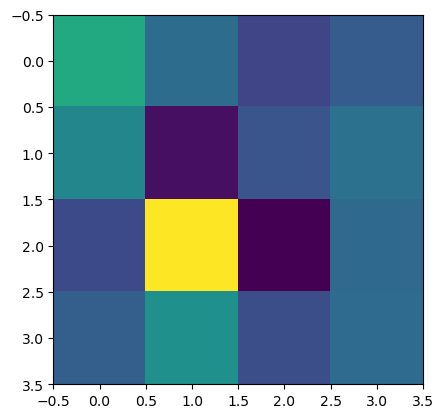

In [21]:
size = int(np.sqrt(shap_values.shape[1]))
plt.imshow(shap_values[2].reshape(size, size).cpu().numpy(), cmap="viridis")
shap_values[2].min().item(), shap_values[2].max().item()

In [22]:
explainer = Explainer.load_from_checkpoint(
    # PROJECT_ROOT / "vit_shapley/modules/checkpoints_explainer_num_players_16/lightning_logs/version_0/checkpoints/epoch=99-step=140700.ckpt",
    #PROJECT_ROOT / "checkpoints/explainer/_player16_lr1e-05_wd0.0_b256/lightning_logs/version_2/checkpoints/epoch=2-step=528.ckpt",
    # PROJECT_ROOT / "saved_models/explainer/_player16_lr0.0001_wd0.0_b128/lightning_logs/version_7/checkpoints/epoch=99-step=35200.ckpt",
    PROJECT_ROOT / "checkpoints/explainer/_player16_lr0.0001_wd0.0_b128/lightning_logs/version_7/checkpoints/epoch=99-step=35200.ckpt",
    map_location="cuda",
    surrogate=deepcopy(surrogate),
    # strict=False
)
explainer.eval()
pass

adopt performer encoder for tokens-to-token


tensor(-0.6890) tensor(2.8821)


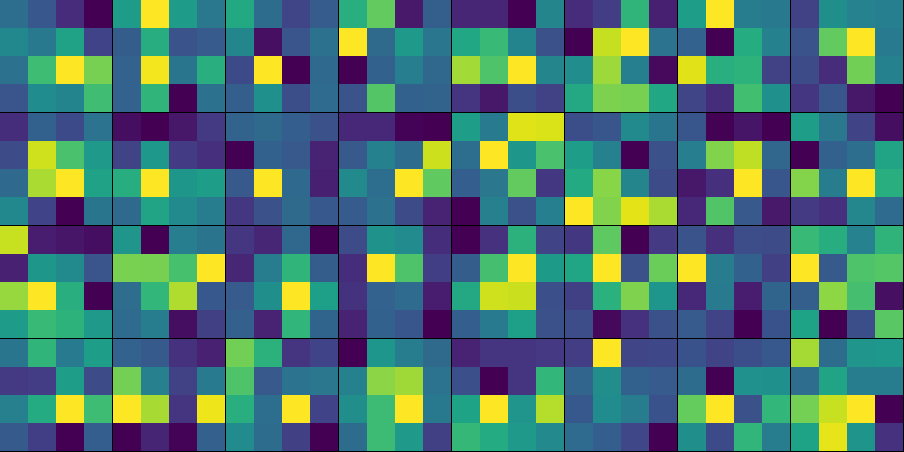

In [23]:
from vit_shapley.CIFAR_10_Dataset import _tensor_to_image, _make_image_grid
import PIL.Image

def get_heatmaps(values: torch.Tensor, images_shape: tuple[int, int, int, int], vmin: float = None, vmax: float = None) -> list[PIL.Image.Image]:
    """
    Args:
    - values: (B, num_players)
    - images_shape: (B, C, H, W)
    """
    B, num_players = shap_values.shape
    _B, C, H, W = images_shape
    assert B == _B and C == 3, f"Shape mismatch {shap_values.shape=}, {images_shape=}"
    print(values.min(), values.max())

    mask_H = int(np.round(np.sqrt(num_players)))
    mask_W = mask_H
    assert mask_H * mask_W == num_players, f"{num_players=}, expected a square number."
    values = values.view(B, mask_H, mask_W)

    # Upscale masks to image size.
    h_repeats, w_repeats = int(np.ceil(H / mask_H)), int(np.ceil(W / mask_W))
    values = values.repeat_interleave(h_repeats, dim=1).repeat_interleave(w_repeats, dim=2)
    values = values[:, :H, :W]

    if vmin is None:
        # vmin = values.min()
        vmin = values.min(dim=2, keepdim=True)[0].min(dim=1, keepdim=True)[0]
    if vmax is None:
        # vmax = values.max()
        vmax = values.max(dim=2, keepdim=True)[0].max(dim=1, keepdim=True)[0]
    values = (values - vmin) / (vmax - vmin + 1e-8)  # Normalize to [0, 1]

    color_map = plt.get_cmap('viridis')
    values = color_map(values)  # (B, H, W, 4)
    values = values[:, :, :, :3]  # Remove alpha channel
    values = torch.tensor(values).permute(0, 3, 1, 2)  # (B, C, H, W)

    # values = values.unsqueeze(dim=1).expand(-1, 3, -1, -1)  # Add C dimension
    # Masks now have shape (B, 1, H, W)

    return [_tensor_to_image(v, scale=0.5, mean=0, std=1) for v in values]

heatmap_grid = _make_image_grid(get_heatmaps(shap_values, images.shape))
heatmap_grid

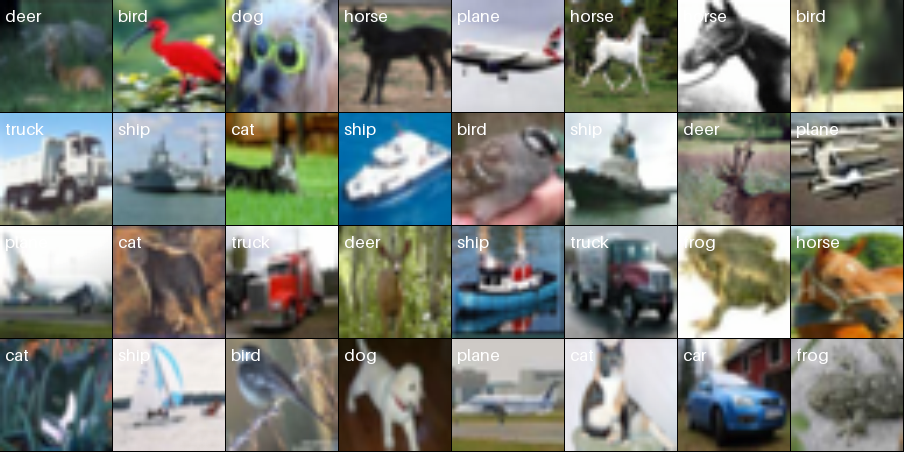

In [24]:
image_grid = CIFAR_10_Dataset.to_image_grid(images, labels, scale=0.5)
image_grid

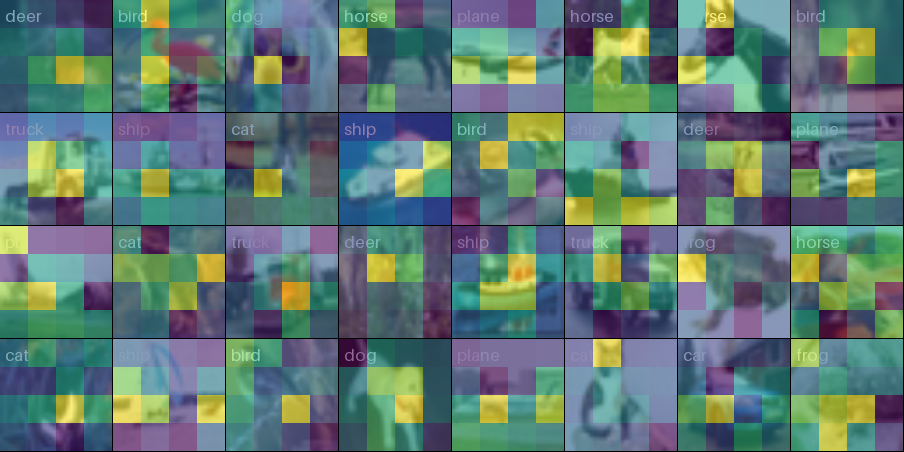

In [25]:
PIL.Image.blend(image_grid, heatmap_grid, alpha=0.6)

In [26]:
with torch.no_grad():
    shap_values_explainer = explainer(images.to(explainer.device)).cpu()  # (batch=32, num_players=196, num_classes=10)
shap_values_explainer = shap_values_explainer[torch.arange(shap_values_explainer.shape[0]), :, labels] # (batch, num_players)
shap_values_explainer.shape

torch.Size([32, 16])

tensor(0.0549) tensor(0.0568)


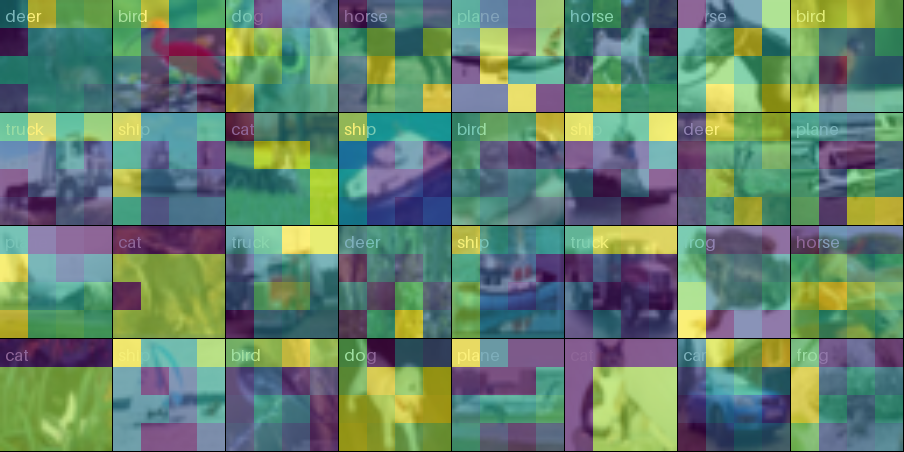

In [27]:
heatmap_grid_explainer = _make_image_grid(get_heatmaps(shap_values_explainer, images.shape))

PIL.Image.blend(image_grid, heatmap_grid_explainer, alpha=0.6)

# Test best/worst/closest/furthest feature masking

In [11]:
from typing import Literal


def remake_masks(
    images: torch.Tensor,
    masks: torch.Tensor,
    targets: torch.Tensor,
    players_to_mask: Literal["best", "worst", "central", "peripheral", "random"],
    explainer: torch.nn.Module
) -> torch.Tensor:
    """
    Remake masks in a given batch according to a given strategy, keeping the same percentage of 0s and 1s.

    Args:
    - images: (B, C, H, W)
    - masks: (B, num_masks_per_image, num_players)
    - targets: (B,)
    - players_to_mask:
        - "best", "worst": mask (zero out) the players with the highest/lowest SHAP values for the target class, as estimated by the explainer.
        - "central", "peripheral": mask the players closest to/furthest from the center of the image.
        - "random": mask random players (resampled for each item in the batch).
    - explainer

    Returns new masks of shape (B, num_masks_per_image, explainer.surrogate.num_players)
    """
    B = images.shape[0]
    num_players = explainer.surrogate.num_players

    # From the masks in the batch we only take the percaentage of 0s and 1s.
    num_zeroes = masks.shape[2] - masks.sum(dim=2)  # (B, num_masks_per_image)
    # Rescale to the wanted number of players, keeping the same percentage of 0s and 1s.
    num_zeroes = (num_zeroes * num_players / masks.shape[2]).round()

    if players_to_mask in ["best", "worst"]:
        shap_values = explainer(images)  # (B, num_players, num_classes)
        # shap_values[b, p] := shap_values[b, p, targets[b]]
        shap_values = shap_values[torch.arange(shap_values.shape[0]), :, targets]  # (B, num_players)
        assert shap_values.shape == (B, num_players)
        return make_masks_from_player_values(num_zeroes=num_zeroes, player_values=shap_values, players_to_mask=players_to_mask)
    elif players_to_mask in ["central", "peripheral", "random"]:
        distances = get_distances_from_center(num_players).to(images.device).expand(B, num_players)
        if players_to_mask == "central":
            players_to_mask = "worst"
        elif players_to_mask == "peripheral":
            players_to_mask = "best"
        return make_masks_from_player_values(num_zeroes=num_zeroes, player_values=distances, players_to_mask=players_to_mask)
    else:
        raise ValueError(f"{players_to_mask=}")


def test_masked(surrogate: torch.nn.Module, dataloader: torch.utils.data.DataLoader, explainer: torch.nn.Module, players_to_mask: Literal["best", "worst", "random", "central", "peripheral"], device="cuda") -> None:
    results = []
    masked_percentages = []
    explainer.eval()
    surrogate.eval()
    with torch.no_grad():
        explainer.to(device)
        surrogate.to(device)
        correct, total = 0, 0
        with tqdm(dataloader, desc=players_to_mask) as dataloader_progress:
            for batch in dataloader_progress:
                images, masks, targets = batch['images'], batch['masks'], batch['labels']
                images, masks, targets = images.to(device), masks.to(device), targets.to(device)

                masks = remake_masks(images, masks, targets, players_to_mask, explainer).to(device)
                images, masks, targets = apply_masks_to_batch(images, masks, targets)

                logits = surrogate(images)
                _, predicted = logits.max(dim=1)
                total += targets.shape[0]
                correct += predicted.eq(targets).sum().item()
                results.extend(predicted.eq(targets).cpu().numpy())
                masked_percentages.extend((1 - masks.float()).mean(dim=1).cpu().numpy() * 100)
                dataloader_progress.set_postfix_str(f'Accuracy: {100.0 * correct / total:.2f}%')
    return pd.DataFrame({'result': results, 'masked %': masked_percentages})

all_results = {}

In [12]:
import IPython.display
import ipywidgets

def plot(all_results: dict[str, pd.DataFrame], bucket_size: float = 100 / 14) -> None:
    # Smooth the plot by rounding 'masked %' to the nearest multiple of bucket_size.
    plot_results = deepcopy(all_results)
    for k, df in plot_results.items():
       df['masked %'] = df['masked %'].div(bucket_size).round().astype(int).mul(bucket_size)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    for i, ax in enumerate(axs):
        for k, df in plot_results.items():
            ax.errorbar(
                x=list(df.groupby('masked %').groups.keys()),
                y=df.groupby('masked %').mean()["result"].to_list(),
                yerr=df.groupby('masked %').sem()["result"].mul(3).to_list(),
                label=k
            )
        ax.plot([0, 100], [0.97, 0.97], color='black', linestyle='dashed', linewidth=0.7, label='97%')
        ax.legend()
        ax.set_xlabel('masked %')
        ax.set_ylabel('accuracy')
        if i == 0:
            ax.set_xlim(0, 100)
            ax.set_ylim(0.4, 1)
        else:
            ax.set_xlim(0, 20)
            ax.set_ylim(0.9, 1)
    plt.show()

# Make a sub-output for updating the plot live.
plot_output = ipywidgets.Output()
IPython.display.display(plot_output)

with tqdm(range(2), desc="repeats") as repeats:
    for repeat in repeats:
        for players_to_mask in ["central", "peripheral", "random", "best", "worst"]:
            # Update plot
            plot_output.clear_output(wait=False)
            with plot_output:
                plot(all_results)
            # Test and update results
            df = test_masked(surrogate, datamodule.test_dataloader(), explainer, players_to_mask)
            if players_to_mask not in all_results:
                all_results[players_to_mask] = df
            else:
                all_results[players_to_mask] = pd.concat([all_results[players_to_mask], df])

# Update plot
plot_output.clear_output(wait=True)
with plot_output:
    plot(all_results)

Output()

repeats:   0%|          | 0/2 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]